# 3. Visual search with k-NN

The idea here is to implement a little search engine based on the high-level image representation and k-nearest neighbors

First, we reimport libraries, arrays and list we are going to use for this section (from previous notebook)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('darkgrid')

from IPython.display import display

In [2]:
class_labels = [0, 1, 2, 3, 4, 5]
class_names = ['bike', 'car', 'motorcycle', 'other', 'truck', 'van'] 
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

with np.load('train_features.npz') as train_data:
    train_features = train_data['features']
    train_labels = train_data['labels']
    train_images = train_data['images']

X_train = np.array(train_features)
y_train = np.array(train_labels)
images_train = np.array(train_images)


with np.load('valid_features.npz') as valid_data:
    valid_features = valid_data['features']
    valid_labels = valid_data['labels']
    valid_images = valid_data['images']

X_valid = np.array(valid_features)
y_valid = np.array(valid_labels)
images_valid = np.array(valid_images)

with np.load('test_features.npz') as test_data:
    test_features = test_data['features']
    test_labels = test_data['labels']
    test_images = test_data['images']

X_test = np.array(test_features)
y_test = np.array(test_labels)
images_test = np.array(test_images)

## k-NN Classifier
Fit and tune a k-NN classifier. Visualize the train and validation curves. Import necessary libraries from sklearn

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [4]:
knn = KNeighborsClassifier()

# First create a pipeline using Scaler
pipe_with_scaler = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', knn)
])

# Create a second pipeline not using Scaler
pipe_without_scaler = Pipeline([
    ('knn', knn)
])

In [5]:
# Odd values for number of neighbors from 1 to 19
# define a parameter grid for GridSearchCV to search over
param_grid = {
    'knn__n_neighbors': np.arange(1, 20, 2),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

# Create GridSearchCV object
grid_search_with_scaler = GridSearchCV(pipe_with_scaler, param_grid, verbose=1, n_jobs=-1)
grid_search_without_scaler = GridSearchCV(pipe_without_scaler, param_grid, verbose=1, n_jobs=-1)

# Fit grid search
grid_search_with_scaler.fit(X_train, y_train)
grid_search_without_scaler.fit(X_train, y_train)

# Extract best estimator in both cases
best_knn_with_scaler = grid_search_with_scaler.best_estimator_
best_knn_without_scaler = grid_search_without_scaler.best_estimator_

# Print score for train and validation for best estimator
train_scores_with_scaler = best_knn_with_scaler.score(X_train, y_train)
valid_scores_with_scaler = best_knn_with_scaler.score(X_valid, y_valid)

train_scores_without_scaler = best_knn_without_scaler.score(X_train, y_train)
valid_scores_without_scaler = best_knn_without_scaler.score(X_valid, y_valid)

print('With scaler: Train score:', train_scores_with_scaler)
print('With scaler: Validation score:', valid_scores_with_scaler)
print('Without scaler: Train score:', train_scores_without_scaler)
print('Without scaler: Validation score:', valid_scores_without_scaler)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
With scaler: Train score: 1.0
With scaler: Validation score: 0.920863309352518
Without scaler: Train score: 1.0
Without scaler: Validation score: 0.9136690647482014


Now that we know rescaling does not dramatically improve performance, we find best param without scaler. Scaling might also lose some information.

In [6]:
print(grid_search_without_scaler.best_params_)

{'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}


Now we save results from train and validation set to a dataframe iterating over values of K

In [7]:
knn = KNeighborsClassifier(
    p=1,
    weights='distance'    
)

gs_results =[]
for k in np.arange(1, 20, 2):      
    knn.set_params(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Save model and its performance on train/test sets
    gs_results.append(
        {
            "k": k,
            "train_accuracy": knn.score(X_train, y_train),
            "valid_accuracy": knn.score(X_valid, y_valid),
        }
    )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results

,k,train_accuracy,valid_accuracy
0,1,1.0,0.892086
1,3,1.0,0.913669
2,5,1.0,0.884892
3,7,1.0,0.899281
4,9,1.0,0.856115
5,11,1.0,0.870504
6,13,1.0,0.856115
7,15,1.0,0.863309
8,17,1.0,0.848921
9,19,1.0,0.856115


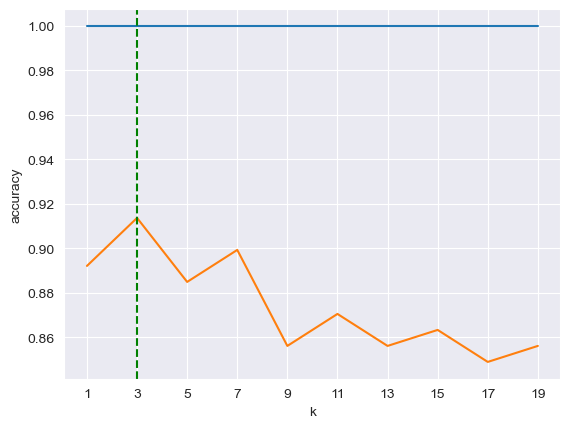

In [8]:
# Plot validation curves
plt.plot(gs_results["k"], gs_results["train_accuracy"], label="train curve")
plt.plot(gs_results["k"], gs_results["valid_accuracy"], label="validation curve")
plt.ylabel("accuracy")
plt.xlabel("k")
plt.axvline(x=3, color='green', linestyle='--')
plt.grid(True)
plt.xticks(np.arange(1, 20, 2))
plt.show()

The best performance is obtained for k=3

## Test dataset
### Classification report

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Fit knn with best parameters obtained from grid search
knn = KNeighborsClassifier(
    n_neighbors=3,
    p=1,
    weights='distance'    
)

knn.fit(X_train, y_train)

# Predicts category of test dataset
y_pred = knn.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12
         1.0       0.92      1.00      0.96        11
         2.0       1.00      1.00      1.00         9
         3.0       1.00      1.00      1.00         6
         4.0       1.00      1.00      1.00         7
         5.0       1.00      0.80      0.89         5

    accuracy                           0.98        50
   macro avg       0.99      0.97      0.97        50
weighted avg       0.98      0.98      0.98        50



### Confusion matrix

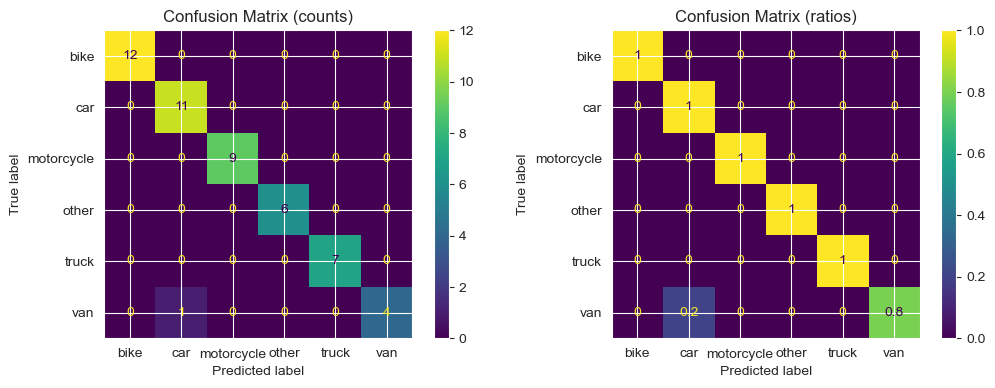

In [10]:
# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=class_names, ax=ax1)

# Plots normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, normalize="true", display_labels=class_names, ax=ax2)

plt.show()

One van are improperly classified as a car

## Neighbors
### Correctly classified
Pick an image which was correctly classified in the test set and plot its 10 nearest neighbors from the training set. An example is depicted below

We use np.where to find indices of correctly classified and missclassified samples, comparing y_test value and y_pred.

In [11]:
correct_indices = np.where(y_test == y_pred)[0]

# Pick first missclassified sample
correct_index = correct_indices[0]

# Get features of this missclassified samples
correct_sample = X_test[correct_index]

# Using kneigbors we find 10 most related samples in X_train (knn was fitted on X_train)
_ , indices = knn.kneighbors([correct_sample], n_neighbors=10)

# Indices and labels of neighbors
print("Indices of neighbors: ", indices[0])
print("Labels of neighbors: ", y_train[indices[0]])

Indices of neighbors:  [160  74  57 154 121 134 156 263  20 139]
Labels of neighbors:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


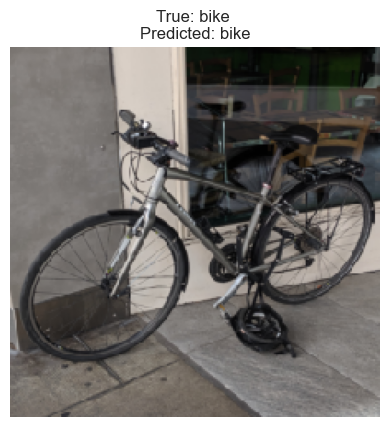

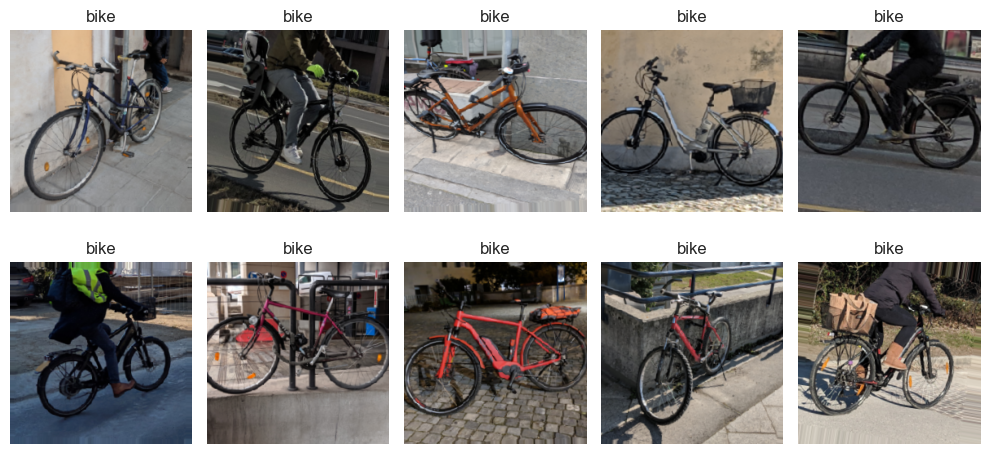

In [12]:
# We concatenate an image title
predicted_name = class_names[int(y_pred[correct_index])]
true_name = class_names[int(test_labels[correct_index])]
image_title = f"True: {true_name} \nPredicted: {predicted_name}"

plt.imshow(test_images[correct_index])
plt.axis('off')
plt.title(image_title)

# Then we plot closest neighbors from training set
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
axes = axes.flatten()

for i, index in enumerate(indices[0]):  
    axes[i].imshow(train_images[index])
    axes[i].axis('off')
    axes[i].set_title(class_names[int(train_labels[index])])

plt.tight_layout()
plt.show()

These are effectively bikes

### Misclassified
Pick an image which was misclassified in the test set and plot its 10 neighbors from the training set. Using kneigbors we find 10 most related samples in X_train, as knn was fitted on X_train.

In [13]:
misclassified_indices = np.where(y_test != y_pred)[0]

# Pick first missclassified sample
misclassified_index = misclassified_indices[0]

# Get features of this missclassified samples
misclassified_sample = X_test[misclassified_index]

# Using kneigbors we find 10 most related samples in X_train (knn was fitted on X_train)
_ , indices = knn.kneighbors([misclassified_sample], n_neighbors=10)

# Indices and labels of neighbors
print("Indices of neighbors: ", indices[0])
print("Labels of neighbors: ", y_train[indices[0]])

Indices of neighbors:  [ 33 177 228 271 157 115  85 207 272 102]
Labels of neighbors:  [1. 5. 1. 1. 1. 1. 1. 1. 1. 1.]


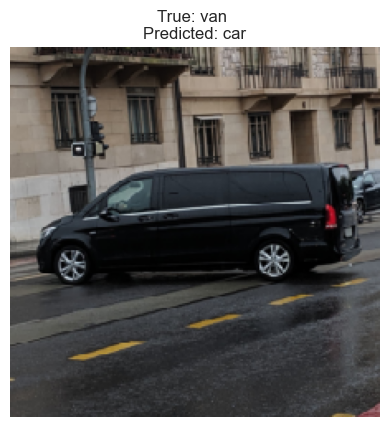

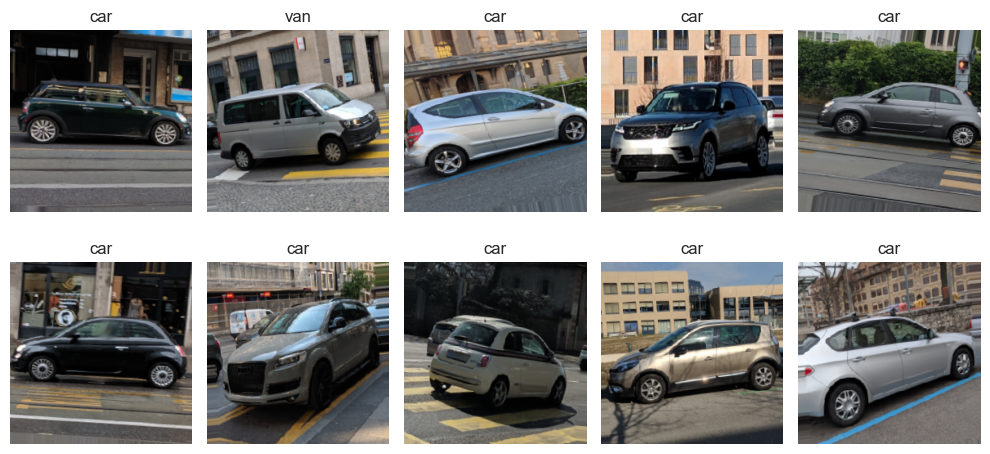

In [14]:
# We concatenate an image title
predicted_name = class_names[int(y_pred[misclassified_index])]
true_name = class_names[int(test_labels[misclassified_index])]
image_title = f"True: {true_name} \nPredicted: {predicted_name}"

plt.imshow(test_images[misclassified_index])
plt.axis('off')
plt.title(image_title)

# Then we plot closest neighbors from training set
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
axes = axes.flatten()

for i, index in enumerate(indices[0]):  
    axes[i].imshow(train_images[index])
    axes[i].axis('off')
    axes[i].set_title(class_names[int(train_labels[index])])

plt.tight_layout()
plt.show()